# Project : Stock Market Analysis

Time-series analysis is a statistical technique used to analyze and model data points collected or recorded at specific time intervals. The goal of time-series analysis is to understand the underlying patterns in the data, make forecasts, and detect any trends, seasonal variations, or cycles.

In this project, we will explore the stock market using the provided AAPL.csv dataset and develop predictive models, such as SARIMA, LSTM, and others to forecast the highest stock price for each day.

About the dataset (daily stock price data):
* **Date:** Trading day.
* **Open:** Opening price of the stock at the start of the trading session.
* **High:** Highest price of the stock during the trading session.
* **Low:** Lowest price of the stock during the trading session.
* **Close:** Closing price of the stock at the end of the trading session.
* **Adj Close:** Adjusted closing price (adjusts for factors like dividends or stock splits).
* **Volume:** Trading volume, the number of shares traded in the day.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
data=pd.read_csv("D:\DS\AAPL.csv", index_col=0)
data.head()

,Adj Close,Close,High,Low,Open,Volume
Price,,,,,,
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
2020-01-02,72.79601287841797,75.0875015258789,75.1500015258789,73.79750061035156,74.05999755859375,135480400
2020-01-03,72.08828735351562,74.35749816894531,75.1449966430664,74.125,74.2874984741211,146322800
2020-01-06,72.66271209716797,74.94999694824219,74.98999786376953,73.1875,73.44750213623047,118387200
2020-01-07,72.32096099853516,74.59750366210938,75.2249984741211,74.37000274658203,74.95999908447266,108872000


In [4]:
data.drop('Ticker', axis=0, inplace=True)

In [5]:
data.tail()

,Adj Close,Close,High,Low,Open,Volume
Price,,,,,,
2024-11-22,229.8699951171875,229.8699951171875,230.72000122070312,228.05999755859375,228.05999755859375,38168300
2024-11-25,232.8699951171875,232.8699951171875,233.25,229.74000549316406,231.4600067138672,90152800
2024-11-26,235.05999755859375,235.05999755859375,235.57000732421875,233.3300018310547,233.3300018310547,45986200
2024-11-27,234.92999267578125,234.92999267578125,235.69000244140625,233.80999755859375,234.47000122070312,33498400
2024-11-29,237.3300018310547,237.3300018310547,237.80999755859375,233.97000122070312,234.80999755859375,28481400


In [6]:
data.shape

(1237, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1237 entries, 2020-01-02 to 2024-11-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Adj Close  1237 non-null   object
 1   Close      1237 non-null   object
 2   High       1237 non-null   object
 3   Low        1237 non-null   object
 4   Open       1237 non-null   object
 5   Volume     1237 non-null   object
dtypes: object(6)
memory usage: 67.6+ KB


In [8]:
data.duplicated().any()

False

In [9]:
data.index = pd.to_datetime(data.index)
data.head()

,Adj Close,Close,High,Low,Open,Volume
Price,,,,,,
2020-01-02,72.79601287841797,75.0875015258789,75.1500015258789,73.79750061035156,74.05999755859375,135480400
2020-01-03,72.08828735351562,74.35749816894531,75.1449966430664,74.125,74.2874984741211,146322800
2020-01-06,72.66271209716797,74.94999694824219,74.98999786376953,73.1875,73.44750213623047,118387200
2020-01-07,72.32096099853516,74.59750366210938,75.2249984741211,74.37000274658203,74.95999908447266,108872000
2020-01-08,73.48435974121094,75.79750061035156,76.11000061035156,74.29000091552734,74.29000091552734,132079200


## Build an ARIMA (SARIMA) model to predict the highest stock price each day

In [10]:
time_series=data[['High']]
time_series.head()

,High
Price,
2020-01-02,75.1500015258789
2020-01-03,75.1449966430664
2020-01-06,74.98999786376953
2020-01-07,75.2249984741211
2020-01-08,76.11000061035156


In [11]:
time_series['High']=time_series['High'].astype(float)

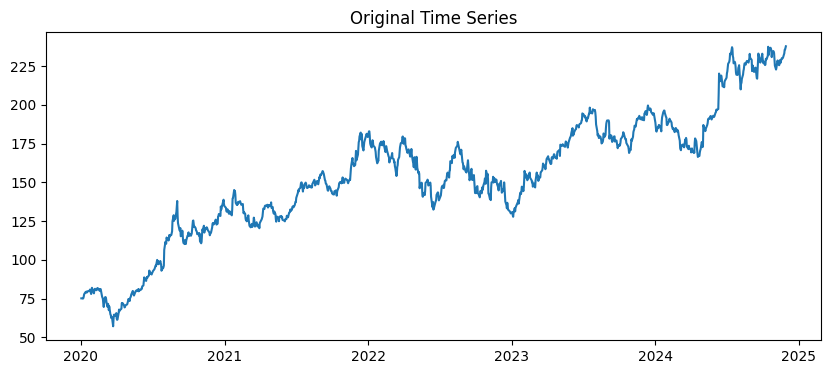

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(time_series)
plt.title('Original Time Series')
plt.show()

The average values change, and the series shows an upward trend over time.

In [ ]:
# Check the stationarity of the data
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if (result[1]<0.05):
        print('Data is stationary')
    else:
        print('Data is not stationary')

adf_test(time_series)

ADF Statistic: -1.0232634851189846
p-value: 0.7446852069595462
Data is not stationary


The data is not stationary => Need to apply differencing

In [ ]:
diff_series = time_series.diff().dropna()
adf_test(diff_series)

ADF Statistic: -24.716930216492916
p-value: 0.0
Data is stationary


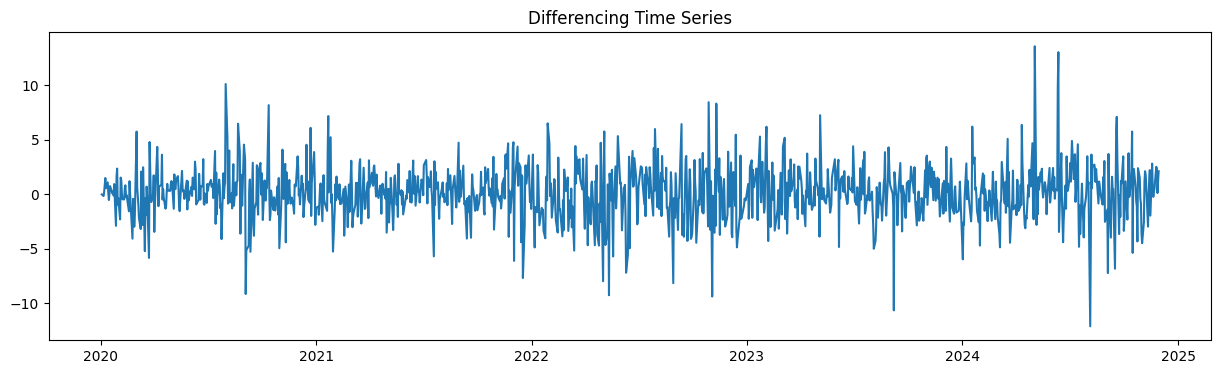

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(diff_series)
plt.title('Differencing Time Series')
plt.show()

After differencing, the series has become stationary, with the average value remaining constant, and the series is now flat => Choose d=1

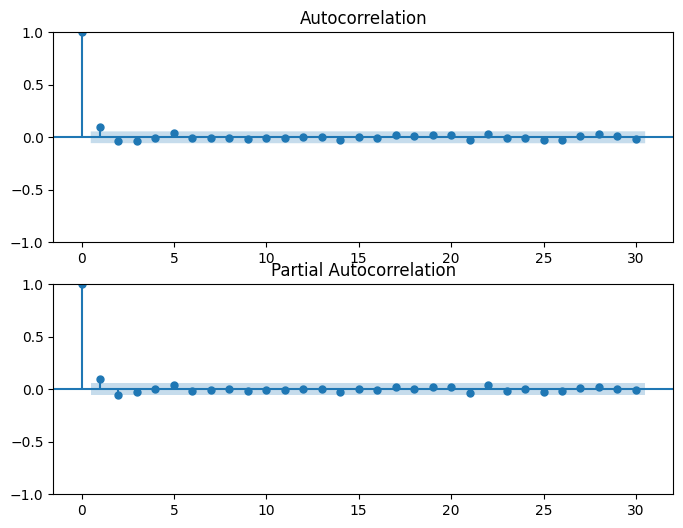

In [ ]:
# Plot ACF and PACF to choose trị p, q
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(diff_series, ax=ax[0], lags = 30, alpha= 0.05)
plot_pacf(diff_series, ax=ax[1], lags= 30, alpha =0.05)
plt.show()

Choose p=1, q=1 based on correlation

In [17]:
train_size=int(0.8*time_series.size)
train = time_series.iloc[:train_size]
test = time_series.iloc[train_size:]

In [18]:
model = sm.tsa.ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  989
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2237.665
Date:                Tue, 24 Dec 2024   AIC                           4481.329
Time:                        18:25:35   BIC                           4496.016
Sample:                             0   HQIC                          4486.914
                                - 989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2851      0.298     -0.956      0.339      -0.870       0.299
ma.L1          0.3706      0.289      1.281      0.200      -0.197       0.938
sigma2         5.4291      0.176     30.808      0.0

In [19]:
forecast = pd.DataFrame(model_fit.forecast(steps=int(test.size)))
forecast.head()

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,predicted_mean
989,194.843192
990,194.716822
991,194.752854
992,194.742580
993,194.745510


In [20]:
forecast.set_index(test.index, inplace=True)

MAE:  20.85496673733597


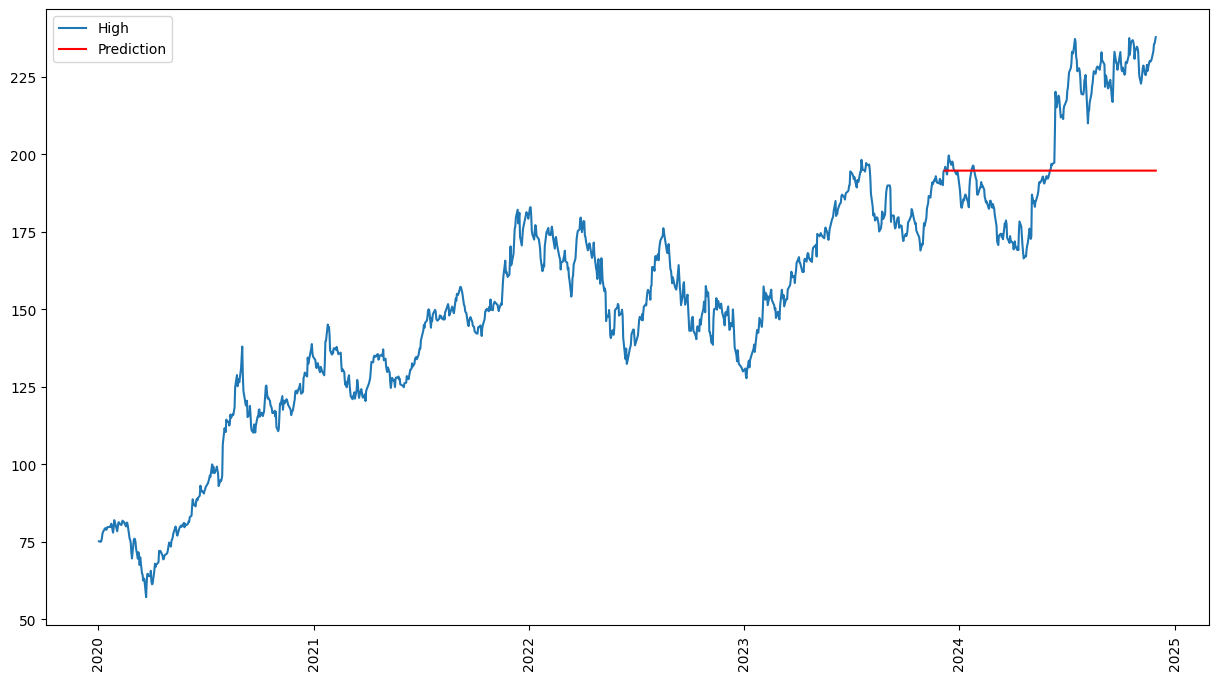

In [ ]:
# Evaluation
print('MAE: ', mean_absolute_error(test, forecast))
plt.figure(figsize=(15,8))
plt.plot(time_series.iloc[1:], label='High')
plt.plot(forecast.iloc[1:], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

The prediction is not accurate, so let's consider the seasonality of the data

<Figure size 1500x1600 with 0 Axes>

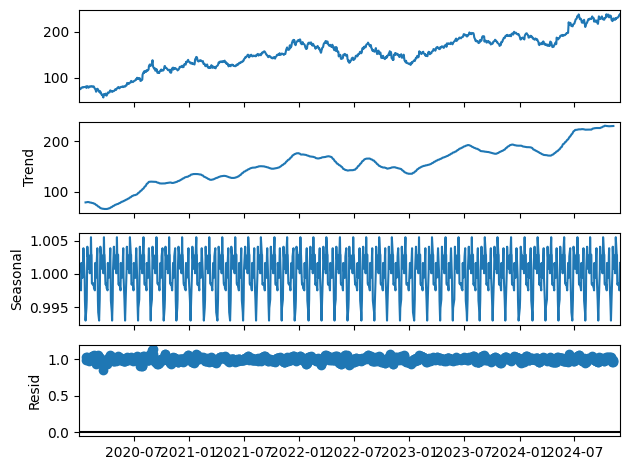

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15,16))
result = seasonal_decompose(time_series, model='multiplicative', period= 30)
result.plot()
plt.show()

There is seasonality in the data, we should build SARIMA model

In [23]:
seasonal_data = time_series.diff(30).dropna()
adf_test(seasonal_data)

ADF Statistic: -4.937418189219933
p-value: 2.9474156455847206e-05
Data is stationary


After differencing, data is stationary => D=1 

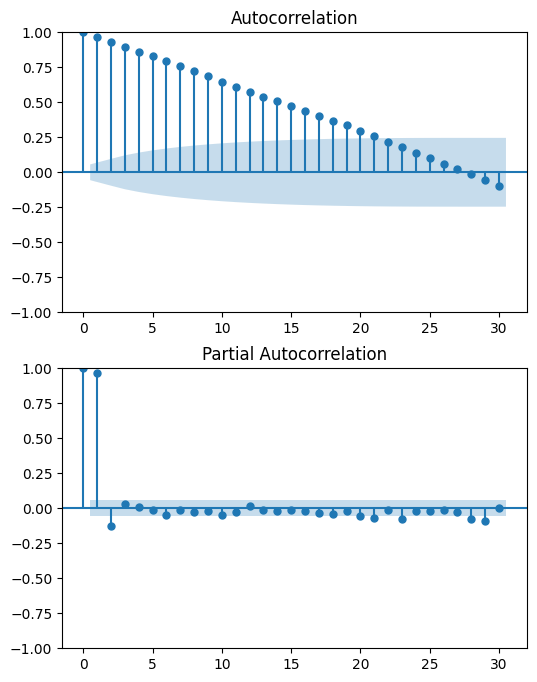

In [ ]:
# Plot ACF and PACF of differenced data
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
plot_acf(seasonal_data, ax=ax[0], lags = 30)
plot_pacf(seasonal_data, ax=ax[1], lags= 30)
plt.show()

- PACF : Choose P=2
- ACF : Choose Q=5

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:                                             High   No. Observations:                  989
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3, 4, 5], 30)   Log Likelihood               -2218.738
Date:                                          Tue, 24 Dec 2024   AIC                           4457.477
Time:                                                  16:57:37   BIC                           4506.125
Sample:                                                       0   HQIC                          4476.005
                                                          - 989                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


MAE:  13.789679786407431


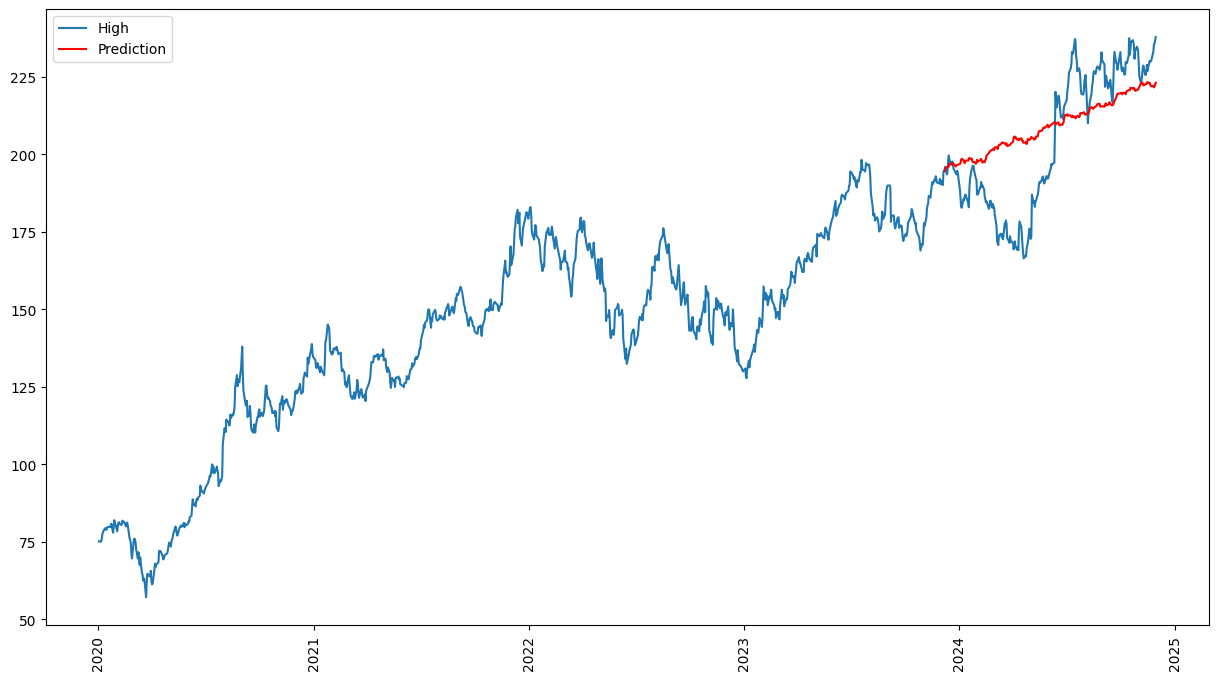

In [ ]:
model=sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(2,1,5,30))
model_fit_sa = model.fit()
print(model_fit_sa.summary())

forecast_sa = pd.DataFrame(model_fit_sa.forecast(steps=int(test.size)))
forecast_sa.set_index(test.index, inplace=True)

# Evaluation
print('MAE: ', mean_absolute_error(test, forecast_sa))
plt.figure(figsize=(15,8))
plt.plot(time_series.iloc[1:], label='High')
plt.plot(forecast_sa.iloc[1:], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

- From the chart, we can see that SARIMA predicts the trend of the data more accurately than the ARIMA model; however, the accuracy is still not high.
- The MAE of the SARIMA model is lower than that of ARIMA, indicating that the SARIMA model predicts more accurately than ARIMA.

## Build AUTO-ARIMA model

In [27]:
auto_model=auto_arima(train, d=1, max_p=5, m=1,
                      start_P=0, seasonal=False,
                      D=0, trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4482.907, Time=2.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4484.483, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4479.907, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4479.517, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4485.116, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4480.970, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4480.943, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4482.833, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4479.775, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.830 seconds


In [28]:
print(auto_model.aic())

4479.516869861037


AIC of Auto-Arima model is smaller than that of SARIMA model

In [29]:
auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [30]:
auto_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [31]:
forecast_auto = pd.DataFrame(auto_model.predict(n_periods=len(test)), columns=['Prediction']).set_index(test.index)
forecast_auto

c:\Program Files\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Prediction
Price,
2023-12-06,194.898844
2023-12-07,195.019910
2023-12-08,195.140976
2023-12-11,195.262042
2023-12-12,195.383108
...,...
2024-11-22,224.317905
2024-11-25,224.438971
2024-11-26,224.560037


MAE:  13.775643968138816


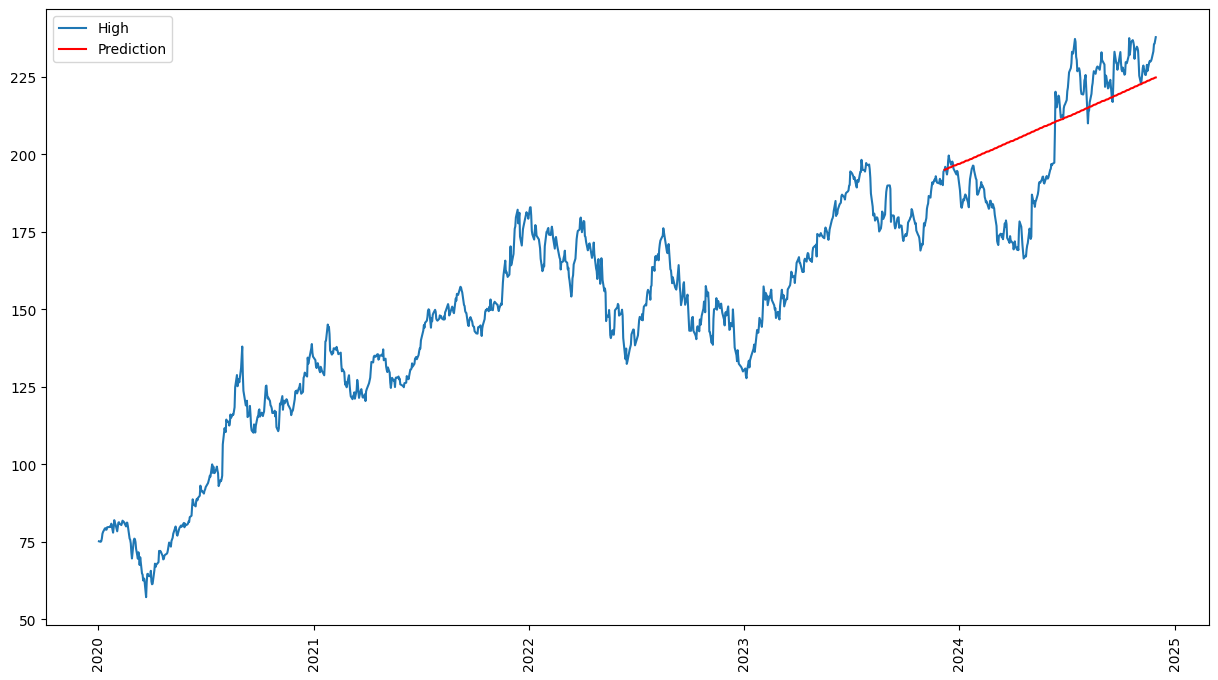

In [ ]:
# Evaluation
print('MAE: ', mean_absolute_error(test, forecast_auto))
plt.figure(figsize=(15,8))
plt.plot(time_series.iloc[1:], label='High')
plt.plot(forecast_auto.iloc[1:], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

The MAE of the AUTO-ARIMA model is lower than that of SARIMA, indicating that the AUTO-ARIMA model predicts slightly more accurately than SARIMA.

## Build Random Forest and XGBoost models

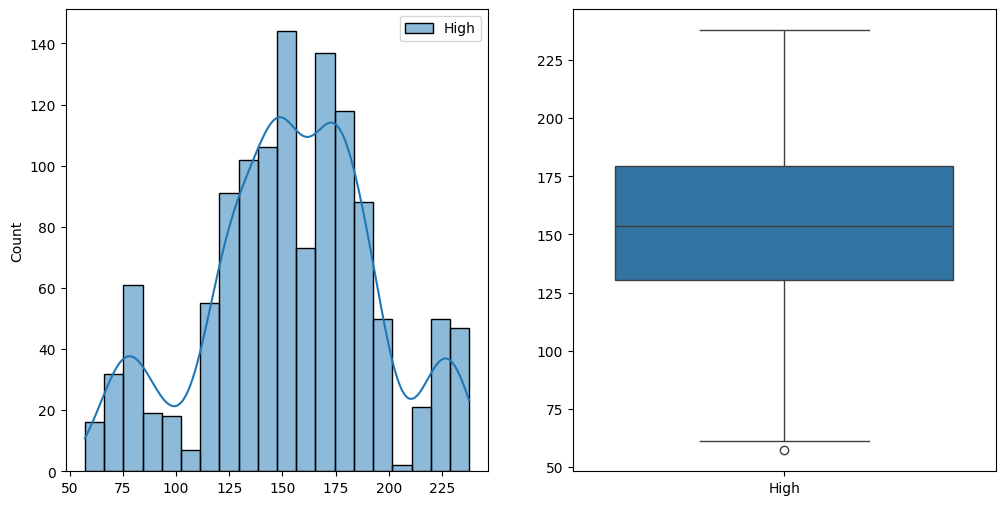

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(time_series, kde=True)
plt.subplot(1,2,2)
sns.boxplot(time_series)
plt.show()

In [102]:
scaler=MinMaxScaler()
time_series_scaled=scaler.fit_transform(time_series)

In [275]:
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X, y = create_dataset(np.array(time_series_scaled), 120)

In [276]:
def train_test_split_series(X, y, train_size):
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_series(X, y, 0.7)

In [277]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((781, 120, 1), (336, 120, 1), (781, 1), (336, 1))

In [278]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)

y_train_flattened = y_train.reshape(-1)
y_test_flattened = y_test.reshape(-1)

print("y_train_flattened shape:", y_train_flattened.shape)
print("y_test_flattened shape:", y_test_flattened.shape)

X_train_reshaped shape: (781, 120)
X_test_reshaped shape: (336, 120)
y_train_flattened shape: (781,)
y_test_flattened shape: (336,)


Random Forest model

In [279]:
model_rf=RandomForestRegressor(n_jobs=-1)
model_rf.fit(X_train_reshaped, y_train_flattened)

RandomForestRegressor(n_jobs=-1)

In [280]:
y_predict = model_rf.predict(X_test_reshaped)

y_predict_actual = scaler.inverse_transform(y_predict.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, y_predict_actual)
mae = mean_absolute_error(y_test_actual, y_predict_actual)
r2 = r2_score(y_test_actual, y_predict_actual)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 339.9719968681659
Mean Absolute Error: 12.65320895149597
R2 Score: 0.3011862566212442


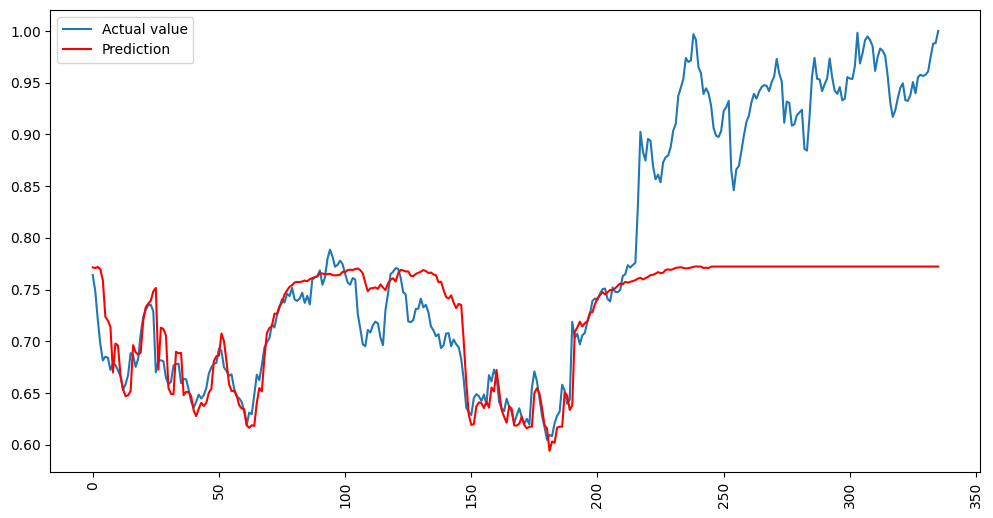

In [281]:
# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual value')
plt.plot(y_predict, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

XGBoost model

In [286]:
model_xgb=xgb.XGBRFRegressor()
model_xgb.fit(X_train_reshaped, y_train_flattened)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

Mean Squared Error: 349.075874816056
Mean Absolute Error: 13.063991319565545
R2 Score: 0.2824732005853513


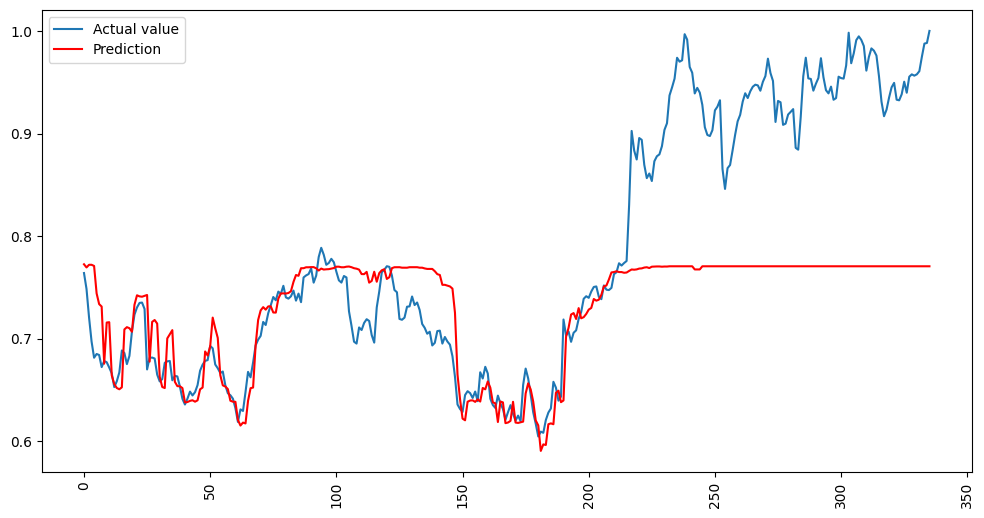

In [ ]:
y_predict = model_xgb.predict(X_test_reshaped)

y_predict_actual = scaler.inverse_transform(y_predict.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mse = mean_squared_error(y_test_actual, y_predict_actual)
mae = mean_absolute_error(y_test_actual, y_predict_actual)
r2 = r2_score(y_test_actual, y_predict_actual)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual value')
plt.plot(y_predict, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

So far, the **Random Forest** model has the lowest MAE, indicating that it is the most accurate in terms of predictions. However, the accuracy is still moderate, and there are times when the forecast deviates significantly.

## Try DEEP LEARNING (LSTM) to build model

In [291]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(12, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(X_train, y_train, batch_size=16, epochs=200)

Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.1408
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0269
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0276
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0228
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0238
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0205
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0194
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0189
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0205
Epoch 10/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0171
Epoch 11/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0185
Epoch 12/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0172
Epoch 13/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0215
Epoch 14/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0163
Epoch 15/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - lo

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Mean Squared Error: 23.710377119860613
Mean Absolute Error: 4.107108570280529
R2 Score: 0.951263228899182


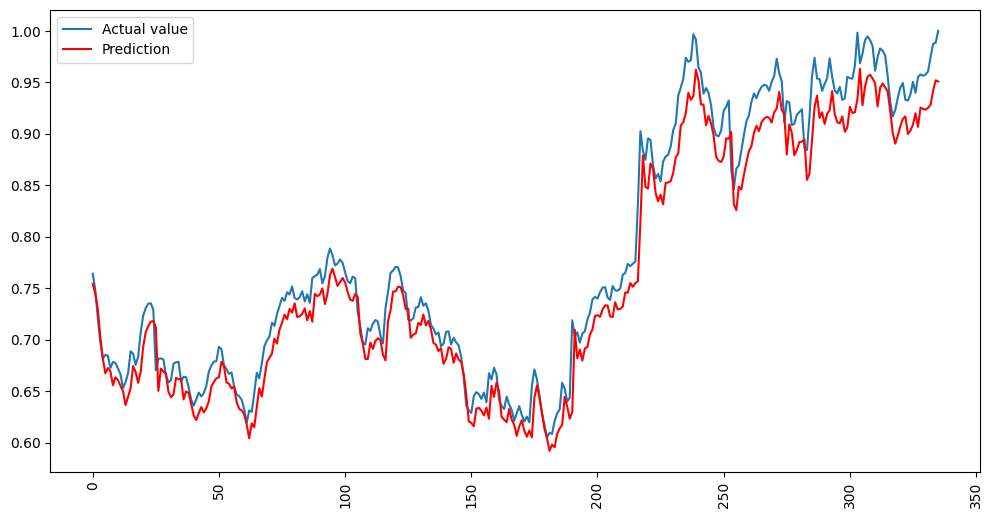

In [292]:
y_predict = model.predict(X_test)

y_predict_actual = scaler.inverse_transform(y_predict.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, y_predict_actual)
mae = mean_absolute_error(y_test_actual, y_predict_actual)
r2 = r2_score(y_test_actual, y_predict_actual)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual value')
plt.plot(y_predict, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

**Deep Learning (LSTM)** outperforms all previous models (SARIMA, AUTO-ARIMA, RANDOM FOREST, XGBOOST), accurately predicting 95% of the data, with a very low MAE.